# Machine Learning model Baseline 
## Kaggle: M5 Forecasting

This notebook is the baseline model for 2020 Kaggle M5 Forecasting competition.

The main model used in this notebook is the LightGBM. 
The high dimensional time-series data is transformed and LightGBM model is used to find patterns in the lag time feature space. 

- **BaseLine steps**：    
                        1. EDA
                        2. Feature Engineering (Time-series feature mining)
                        3. Model Training
                        4. offline validation

---

---
## 1.EDA

To save time, only several results that will directly impact the modeling task will be displayed here. A lot of ideas was originally inspired from public Kernels on Kaggle [EDA](https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda)

- Checked first few rows of sales data

- checked total sales trends aggregated on high level

- checked distribution of sales pattern, refused the hypothesis of Normal distribution

In [0]:
# Run this for Google CoLab
from google.colab import drive
drive.mount('/content/drive')
input_folder = '/content/drive/My Drive/projects/M5_Forecasting/Data/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth',100)

In [0]:
sale_data = pd.read_csv(input_folder+"sales_train_validation.csv")

In [0]:
sale_data.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,3,1,2,2,0,1,1,1,1,0,0,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,3,4,2,1,4,1,3,5,0,6,6,0,0,0,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,3,2,2,2,3,1,0,0,0,0,1,0,4,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


In [0]:
day_data = sale_data[[f'd_{day}' for day in range(1,1914)]]
total_sum = np.sum(day_data,axis=0).values

Text(0, 0.5, 'count')

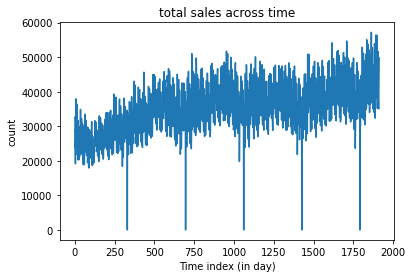

In [0]:
plt.plot(total_sum)
plt.title('total sales across time')
plt.xlabel('Time index (in day)')
plt.ylabel('count')

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'count')

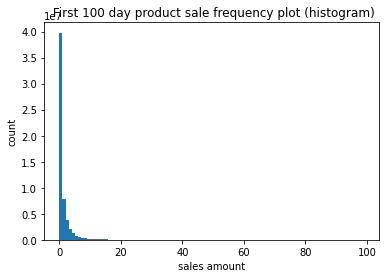

In [0]:
plt.hist(day_data[day_data<100].values.reshape(-1),bins=100);
plt.title(' First 100 day product sale frequency plot (histogram)')
plt.xlabel('sales amount')
plt.ylabel('count')


---
## 2、Feature Engineering


While there are other options of modeling, such as Rule-based modeling, Partial Correlation modeling (ARMA & ARiMA), Trend-based modeling (Prophet), Deep Learning modeling (RNN, LSTM and etc.), the main focus is to use Machine Learning model. Compared to other methods, machine learning models are scalable, and has good model explanability (as compared with Deep Learning Models). 

Main idea of the plan is to extract features from a series of time-lagged sliding windows.  


Time-lagged Windows:

- lag 7 days
- lag 14 days
- lag 28 days
- moving average of past 7 days
- exponential moving average of past 7 days
- moving average of past 14 days
- exponential moving average of past 14 days
- moving average of past 28 days
- exponential moving average of past 28 days

Categorical features from other descriptive tables

- date
- price

In [0]:
import sys
import lightgbm as lgb
from  datetime import datetime, timedelta

In [0]:
def create_train_data(train_start=750,test_start=1800,is_train=True):
    # define data type
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol:"float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # load price data
    price_data = pd.read_csv(input_folder+"sell_prices.csv",dtype=PRICE_DTYPES)
    # load calendar data
    cal_data = pd.read_csv(input_folder+'calendar.csv',dtype=CAL_DTYPES)
    # load sales data
    sale_data = pd.read_csv(input_folder+"sales_train_validation.csv",dtype=SALE_DTYPES,usecols=catcols+numcols)


    # down-cast data type to save memory
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16")
            price_data[col] -= price_data[col].min()

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()


    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    ## notice: in the sample submission file, there are nan entries, so we follow this format pattern
    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan

    sale_data = pd.melt(sale_data,
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    return sale_data


def create_feature(sale_data, is_train=True, day=None):
    # time-lagged sliding windows
    # can add more features here
    # 7, 14, 28 days lagging
    lags = [7, 14, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # shift the daily sales value by the corresponding days (lag)  
    # there are slight differences to create same features for training and testing data 
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date==day-timedelta(days=lag), 'sales'].values  


    # moving average for lag 7, 14 and 28 days
    # from my experience, groups of exponential weighted moving average features are usually more powerful, so anyone can add more features here. 
    wins = [7, 14, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

                sale_data[f"{lag}_{win}_decay_al0.1"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.ewm(alpha=0.1).mean())  #exponential moving average

    else:
        for win in wins:
            for lag in lags:
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"rmean_{lag}_{win}"] = df_window_grouped.sales.values   
               
                weight = np.power(0.9, np.arange(win)[::-1])               #exponential moving average
                wm = lambda x: np.average(x, weights=weight)
                df_window_grouped_decay = df_window.groupby("id").agg(sales=("sales",wm)).reindex(sale_data.loc[sale_data.date==day,'id'])
                sale_data.loc[sale_data.date == day,f"{lag}_{win}_decay_al0.1"] = df_window_grouped_decay.sales.values  



    # extract more categorical features from date
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",
        }

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            sale_data[date_feat_name] = sale_data[date_feat_name].astype("int16")
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")
    return sale_data

In [0]:
sale_data = create_train_data(train_start=350,is_train=True)
sale_data = create_feature(sale_data)


# dropna, drop useless columns and select training features and target feature
## also, one can apply more sophisticated and well-tailored approach to clean the data, such as carefully filling the NA data

sale_data.dropna(inplace=True)
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]
X_train = sale_data[train_cols]
y_train = sale_data["sales"]

In [0]:
X_train.head(5)
X_train.to_pickle(input_folder+'X_train.pkl')

In [0]:
y_train.head(5)
y_train.to_pickle(input_folder+'y_train.pkl')

---

## 3.Model Training

LightGBM model is chosen to train the data.

###  Key take-away
- What loss function should choose?
  - By visualization, we can find that the distribution of the target daily sales data does not follow normal distritbution hypothesis, and thus MSE is not a great choice for Loss function as well as Evaluation Metrics. Instead, the distribution appears to be more like poisson distribution. Because of that, we chose *tweedie* as the objective function, and set *tweedie_variance_power* parameter to 1.2.
One can vary the choice of tweedie_variance_power between [1,2]

- What should we keep in mind when the forecasting target include time range of multiple days instead of a single day?
  - Since in time-series analysis, it is usually assumed that the previous day should have an effect on the next. Thus, in this solution, the prediction of the first day will be used to predict the following day, and so on and so forth.

- LGB model is an advanced model based on GBDT models. One characteristic of GBDT model is that while they perform well in interpolation, it generally lacks the predictive ability to extrapolate information that is outside the range of the available data. In other words, since there is an obvious upward trend in sales, the LGB model will not be able to capture that, so we will need some guidance from other models to close the gap 


<img src='https://github.com/zachwanggg/Kaggle_TimeSeries_M5/blob/master/Sales_frequency_plot.PNG'>



In [0]:
X_train = pd.read_pickle(input_folder+'X_train.pkl')
y_train = pd.read_pickle(input_folder+'y_train.pkl')

In [0]:
def train_model(train_data,valid_data):
    params = {
        "objective" : "tweedie",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
        "nthread": 8,
        "tweedie_variance_power":1.2,
    'verbosity': 1,
    'num_iterations' : 1500,
    'num_leaves': 128,
    "min_data_in_leaf": 104,
    }

    m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

    return m_lgb

In [0]:
def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4, 25)               #start date
    # alphas = [1.035, 1.03, 1.025, 1.02]
    # alphas = [1.028, 1.023, 1.018]
    alphas = [1.035, 1.03, 1.025]
    weights = [1/len(alphas)]*len(alphas)   #weight of each model of the corresponding alpha value (trending coef), and this was used to get a weighted average of predictions from every model
    sub = 0.

    test_data = create_train_data(is_train=False)

    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

        test_data_c = test_data.copy()
        cols = [f"F{i}" for i in range(1,29)]


        for i in range(0, 28):
            day = date + timedelta(days=i)
            print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]
            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)    # 1. multiply trends coef because lgb won't capture trends outside the scope of the sample distribution space (No extrapolation)
                                                                                          #2. iterate over the period of 28 days, prediction of each previous day will have an effect on the day after

        # transformed into submission format
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
        test_sub.fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols] *= weight
        else:
            sub[cols] += test_sub[cols]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()

    # change the validation data (>28days) to evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv(input_folder + "submissionV3.csv",index=False)

In [0]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=cat_feats, free_raw_data=False)
valid_inds = np.random.choice(len(X_train), 10000)
valid_data = lgb.Dataset(X_train.iloc[valid_inds], label = y_train.iloc[valid_inds],categorical_feature=cat_feats, free_raw_data=False) 



In [0]:
m_lgb = train_model(train_data,valid_data) 
predict_ensemble(train_cols,m_lgb)

---
## 4.Offline validation

The calculation of WRMSSE, which is used in this Kaggle competition, is very different from RMSE. 
We can use it to validate the prediction, and on the other hand, it provides guidance for the choice of loss function used in training. 
This implementation is faster than other direct methods. It is resourced from open kernels in the Kaggle community.



In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
import gc

# down-cast data type to save memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:  
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


# load data


# sale
sales = pd.read_csv(input_folder+'sales_train_validation.csv')

# calendar
calendar = pd.read_csv(input_folder+'calendar.csv')
calendar = reduce_mem_usage(calendar)

# price
sell_prices = pd.read_csv(input_folder+'sell_prices.csv')
sell_prices = reduce_mem_usage(sell_prices)

# calculate price
# 按照定义，只需要计算最近的 28 天售卖量（售卖数*价格），通过这个可以得到 weight
# the choice of starting day (1914) can be different 
cols = ["d_{}".format(i) for i in range(1914-28, 1914)]
data = sales[["id", 'store_id', 'item_id'] + cols]

# transform flattened datframe
data = data.melt(id_vars=["id", 'store_id', 'item_id'], 
                 var_name="d", value_name="sale")

# merge with calendar 
data = pd.merge(data, calendar, how = 'left', 
                left_on = ['d'], right_on = ['d'])

data = data[["id", 'store_id', 'item_id', "sale", "d", "wm_yr_wk"]]

# merge with price
data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
data.drop(columns = ['wm_yr_wk'], inplace=True)

# sales*price
data['sale_usd'] = data['sale'] * data['sell_price']

# aggregate to get more time-series on high level
# 30490 -> 42840
# provide more granularity
dummies_list = [sales.state_id, sales.store_id, 
                sales.cat_id, sales.dept_id, 
                sales.state_id + sales.cat_id, sales.state_id + sales.dept_id,
                sales.store_id + sales.cat_id, sales.store_id + sales.dept_id, 
                sales.item_id, sales.state_id + sales.item_id, sales.id]

# here it is to initialize a dataframe or matrix of desired dimensions, which will be used later to host those additional grouped time series data
# 
dummies_df_list =[pd.DataFrame(np.ones(sales.shape[0]).astype(np.int8), 
                               index=sales.index, columns=['all']).T]

# aggregate on specified level
for i, cats in enumerate(dummies_list):
    dummies_df_list +=[pd.get_dummies(cats, drop_first=False, dtype=np.int8).T]
    
# get the aggregated new dataframe with additional timeseries
roll_mat_df = pd.concat(dummies_df_list, keys=list(range(12)), 
                        names=['level','id'])#.astype(np.int8, copy=False)

# save new extended dataframe
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
roll_mat_df.to_pickle('roll_mat_df.pkl')

del dummies_df_list, roll_mat_df
gc.collect()


# Calculate the weight of each single time-series:
def get_s(drop_days=0):
    
    """
    drop_days: int, equals 0 by default, so S is calculated on all data.
               If equals 28, last 28 days won't be used in calculating S.
    """
    
    # Length of time series
    d_name = ['d_' + str(i+1) for i in range(1913-drop_days)]
    # get the aggregation result
    sales_train_val = roll_mat_csr * sales[d_name].values

    # 按照定义，前面连续为 0 的不参与计算
    start_no = np.argmax(sales_train_val>0, axis=1)
    
    # changing those consistent 0 entries to nan
    flag = np.dot(np.diag(1/(start_no+1)) , np.tile(np.arange(1,1914-drop_days),(roll_mat_csr.shape[0],1)))<1
    sales_train_val = np.where(flag, np.nan, sales_train_val)

    #  weight of rmsse
    weight1 = np.nansum(np.diff(sales_train_val,axis=1)**2,axis=1)/(1913-start_no-1)
    
    return weight1

S = get_s(drop_days=0)

#  WRMSSE: w 
def get_w(sale_usd):
    """
    """
    # weight of most granular time series
    total_sales_usd = sale_usd.groupby(
        ['id'], sort=False)['sale_usd'].apply(np.sum).values
    
    # get the weight of each time-series on different level
    weight2 = roll_mat_csr * total_sales_usd
    
    return 12*weight2/np.sum(weight2)


W = get_w(data[['id','sale_usd']])

SW = W/np.sqrt(S)

sw_df = pd.DataFrame(np.stack((S, W, SW), axis=-1),index = roll_index,columns=['s','w','sw'])
sw_df.to_pickle(input_folder+'sw_df.pkl')


def rollup(v):
    '''
    '''
    return (v.T*roll_mat_csr.T).T


# calculate WRMSSE metrics
def wrmsse(preds, y_true, score_only=False, s = S, w = W, sw=SW):
    '''
    preds - Predictions: pd.DataFrame of size (30490 rows, N day columns)
    y_true - True values: pd.DataFrame of size (30490 rows, N day columns)
    sequence_length - np.array of size (42840,)
    sales_weight - sales weights based on last 28 days: np.array (42840,)
    '''
    
    if score_only:
        return np.sum(
                np.sqrt(
                    np.mean(
                        np.square(rollup(preds.values-y_true.values))
                            ,axis=1)) * sw *12)
    else: 
        score_matrix = (np.square(rollup(preds.values-y_true.values)) * np.square(w)[:, None]) *12 / s[:, None]
        score = np.sum(np.sqrt(np.mean(score_matrix,axis=1)))
        return score, score_matrix


In [0]:
# get the previously calculated weights

sw_df = pd.read_pickle(input_folder+'sw_df.pkl')
S = sw_df.s.values
W = sw_df.w.values
SW = sw_df.sw.values

roll_mat_df = pd.read_pickle(input_folder+'roll_mat_df.pkl')
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)

print(sw_df.loc[(11,slice(None))].sw)

In [0]:
np.max(sw_df.loc[(11,slice(None))].sw)

In [0]:
sub

---
## 5. Retrain with extended time-series and weights

Suggestion:
- Before precisely tuning the hyperparameters or building more models, one should consider creating enough features and prepare the data. More often than not, features are more important than models. 
 - we have extended total observations of the data from 30490 to 42840, which if one retrain the model with this new dataframe, the prediction performance will be better. 
 - In LGB model, one can specify the weight of each observations. By providing the weight matrix stored as sw_df should also improve the performance
 - As mentioned before, LGB won't be able to learn too much if the data itself simply doesn't cover the domain range. One should consider blending the prediciton from LGB with predictions from other models. Here, we can consider using Prophet or ARiMA model to extract seasonality and trends to model the upward momentum. In my later post, I will post some other methods to blend model predictions for a better result.

